<a href="https://colab.research.google.com/github/rainmaker29/Introduction-to-Tensorflow/blob/master/cats_dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
import logging
import math
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

Downloading data and setting up environment variables to load data

In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_dir = tf.keras.utils.get_file('cats_and_dogs_filterted.zip',origin=_URL,extract=True)

68608000/68606236 [==============================] - 1s 0us/step


In [3]:
zip_dir_base = os.path.dirname(zip_dir)
!find $zip_dir_base -type d -print

/root/.keras/datasets
/root/.keras/datasets/cats_and_dogs_filtered
/root/.keras/datasets/cats_and_dogs_filtered/validation
/root/.keras/datasets/cats_and_dogs_filtered/validation/cats
/root/.keras/datasets/cats_and_dogs_filtered/validation/dogs
/root/.keras/datasets/cats_and_dogs_filtered/train
/root/.keras/datasets/cats_and_dogs_filtered/train/cats
/root/.keras/datasets/cats_and_dogs_filtered/train/dogs


In [0]:
base_dir = os.path.join(os.path.dirname(zip_dir), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures')

In [5]:
#Number of samples

num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr+num_dogs_tr
total_val = num_cats_val + num_dogs_val


print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


In [0]:
BATCH_SIZE = 100  # Number of training examples to process before updating our models variables
IMG_SHAPE  = 150  # Our training data consists of images with width of 150 pixels and height of 150 pixels

##Preprocessing

In [0]:
# train_image_generator      = ImageDataGenerator(rescale=1./255)  # Generator for our training data
# validation_image_generator = ImageDataGenerator(rescale=1./255)  # Generator for our validation data

In [8]:
image_gen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_data_gen = image_gen_train.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_SHAPE,IMG_SHAPE),
                                                     class_mode='binary')

Found 2000 images belonging to 2 classes.


In [9]:
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=BATCH_SIZE,
                                                 directory=validation_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='binary')

Found 1000 images belonging to 2 classes.


In [0]:
sample_training_images, _ = next(train_data_gen) 

In [0]:
def plotImages(images_arr):
  fig,axes = plt.subplots(1,8,figsize=(20,20))
  axes = axes.flatten()
  for img,ax in zip(images_arr,axes):
    ax.imshow(img)
  plt.tight_layout()
  plt.show()

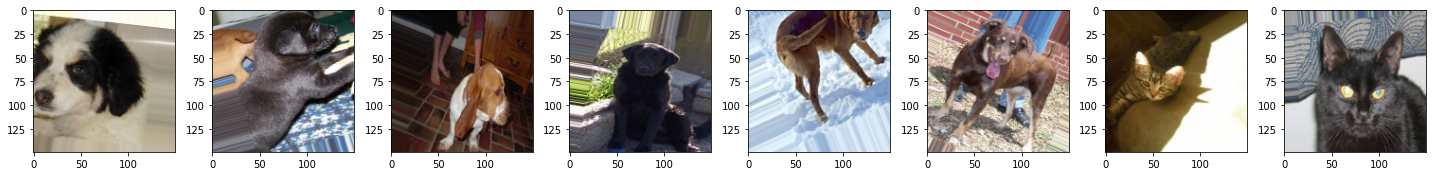

In [12]:
plotImages(sample_training_images[:8])

###Model

In [0]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.5),    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2)
])

In [0]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

In [16]:
EPOCHS = 100
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

Epoch 1/100
20/20 [==============================] - 17s 859ms/step - loss: 0.6972 - accuracy: 0.5245 - val_loss: 0.6929 - val_accuracy: 0.5010
Epoch 2/100
20/20 [==============================] - 18s 883ms/step - loss: 0.6969 - accuracy: 0.4980 - val_loss: 0.6802 - val_accuracy: 0.5370
Epoch 3/100
20/20 [==============================] - 18s 882ms/step - loss: 0.6721 - accuracy: 0.5550 - val_loss: 0.7184 - val_accuracy: 0.5190
Epoch 4/100
20/20 [==============================] - 18s 877ms/step - loss: 0.6897 - accuracy: 0.5350 - val_loss: 0.6618 - val_accuracy: 0.5850
Epoch 5/100
20/20 [==============================] - 18s 882ms/step - loss: 0.6619 - accuracy: 0.5770 - val_loss: 0.6402 - val_accuracy: 0.6190
Epoch 6/100
20/20 [==============================] - 17s 867ms/step - loss: 0.6719 - accuracy: 0.5665 - val_loss: 0.6708 - val_accuracy: 0.5240
Epoch 7/100
20/20 [==============================] - 17s 870ms/step - loss: 0.6647 - accuracy: 0.5775 - val_loss: 0.6420 - val_accuracy:

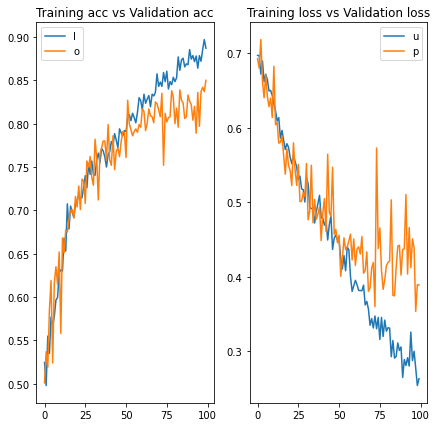

In [17]:
acc = history.history['accuracy']
val_acc  = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(7,7))
plt.subplot(1,2,1)
plt.plot(epochs_range,acc,label='Training accuracy')
plt.plot(epochs_range,val_acc,label='Validation accuracy')
plt.legend('lower right')
plt.title('Training acc vs Validation acc')

plt.subplot(1,2,2)
plt.plot(epochs_range,loss,label='Training loss')
plt.plot(epochs_range,val_loss,label='Validation loss')
plt.legend('upper right')
plt.title('Training loss vs Validation loss')
plt.show()
